<h1>3. Exploratory Data Analysis </h1>

In [1]:
!pip install distance

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape)
print("Number of data points:", df.shape[0])#number of rows
print("Number of data points:", df.shape[1])#number of columns



Number of data points: (404290, 6)
Number of data points: 404290
Number of data points: 6


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [6]:
l=df['is_duplicate']
print(l.shape)

(404290,)


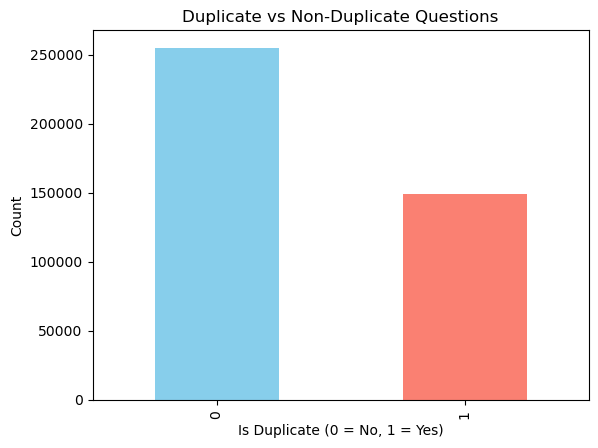

In [7]:
df['is_duplicate'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Duplicate vs Non-Duplicate Questions")
plt.xlabel("Is Duplicate (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [8]:
df['is_duplicate'].value_counts()


is_duplicate
0    255027
1    149263
Name: count, dtype: int64

In [9]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [10]:
# The 'is_duplicate' column contains 0 (not similar) and 1 (similar).
# Taking the mean of this column gives the proportion of '1's (i.e., similar question pairs).

# Calculate and print the percentage of non-similar (is_duplicate = 0)
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(
    100 - round(df['is_duplicate'].mean() * 100, 2)
))
# 100 - mean*100 → gives the percentage of 0s in the column.

# Calculate and print the percentage of similar (is_duplicate = 1)
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(
    round(df['is_duplicate'].mean() * 100, 2)
))
# mean*100 → gives the percentage of 1s (duplicate pairs).


~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [11]:
# Combine all question IDs from both columns 'qid1' and 'qid2' into a single Pandas Series
# This helps us analyze how often each question appears in the dataset.
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

# Count the total number of unique questions
unique_qs = len(np.unique(qids))

# Count how many unique questions appear more than once in the dataset
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

# Print total number of unique questions
print('Total number of Unique Questions are: {}\n'.format(unique_qs))

# Print how many of those questions appear more than once, and their percentage
print('Number of unique questions that appear more than one time: {} ({}%)\n'.format(
    qs_morethan_onetime, qs_morethan_onetime / unique_qs * 100))

# Find the maximum number of times a single question is repeated in the dataset
print('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

# Store the value counts (number of appearances) of each question ID
q_vals = qids.value_counts()

# Convert the Series of counts into a NumPy array for numerical operations (like histograms, analysis, etc.)
q_vals = q_vals.values


Total number of Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



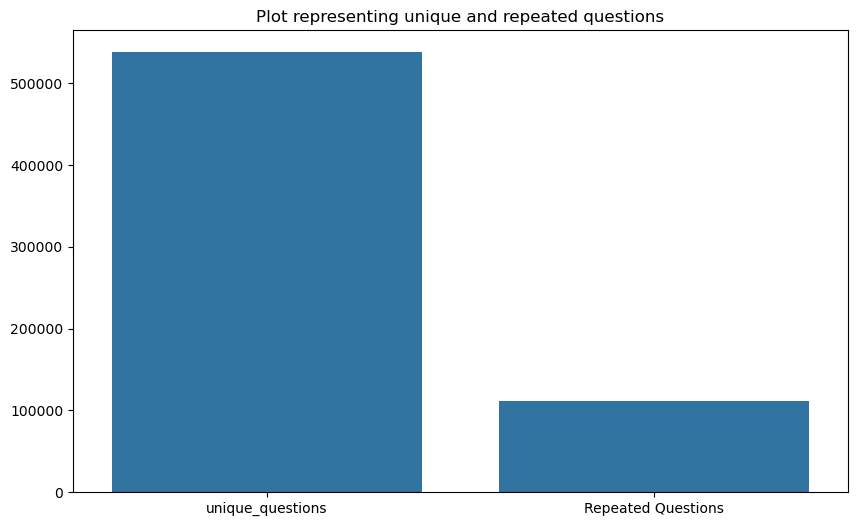

In [12]:
# Define labels for x-axis
x = ["unique_questions" , "Repeated Questions"]

# Define corresponding values (counts) for y-axis
y =  [unique_qs , qs_morethan_onetime]

# Create a figure with specific size (width=10, height=6 inches)
plt.figure(figsize=(10, 6))

# Add a title to the plot
plt.title("Plot representing unique and repeated questions")

# Create a bar plot using seaborn
# x → categories ("unique" and "repeated")
# y → their corresponding counts
sns.barplot(x=x, y=y)

# Display the plot on screen
plt.show()


<h2>Checking for Duplicates

In [13]:
# Checking whether there are any repeated pairs of questions

# Group the DataFrame by both question IDs ('qid1' and 'qid2') 
# and count how many times each unique pair appears.
# The resulting DataFrame (pair_duplicates) has one row per unique (qid1, qid2) pair.
pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

# Compare the number of unique pairs to the total number of rows in the original DataFrame.
# If some pairs were repeated, the grouped DataFrame will have fewer rows.
# Subtracting gives the number of duplicate question pairs.
print("Number of duplicate questions", (pair_duplicates).shape[0] - df.shape[0])


Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

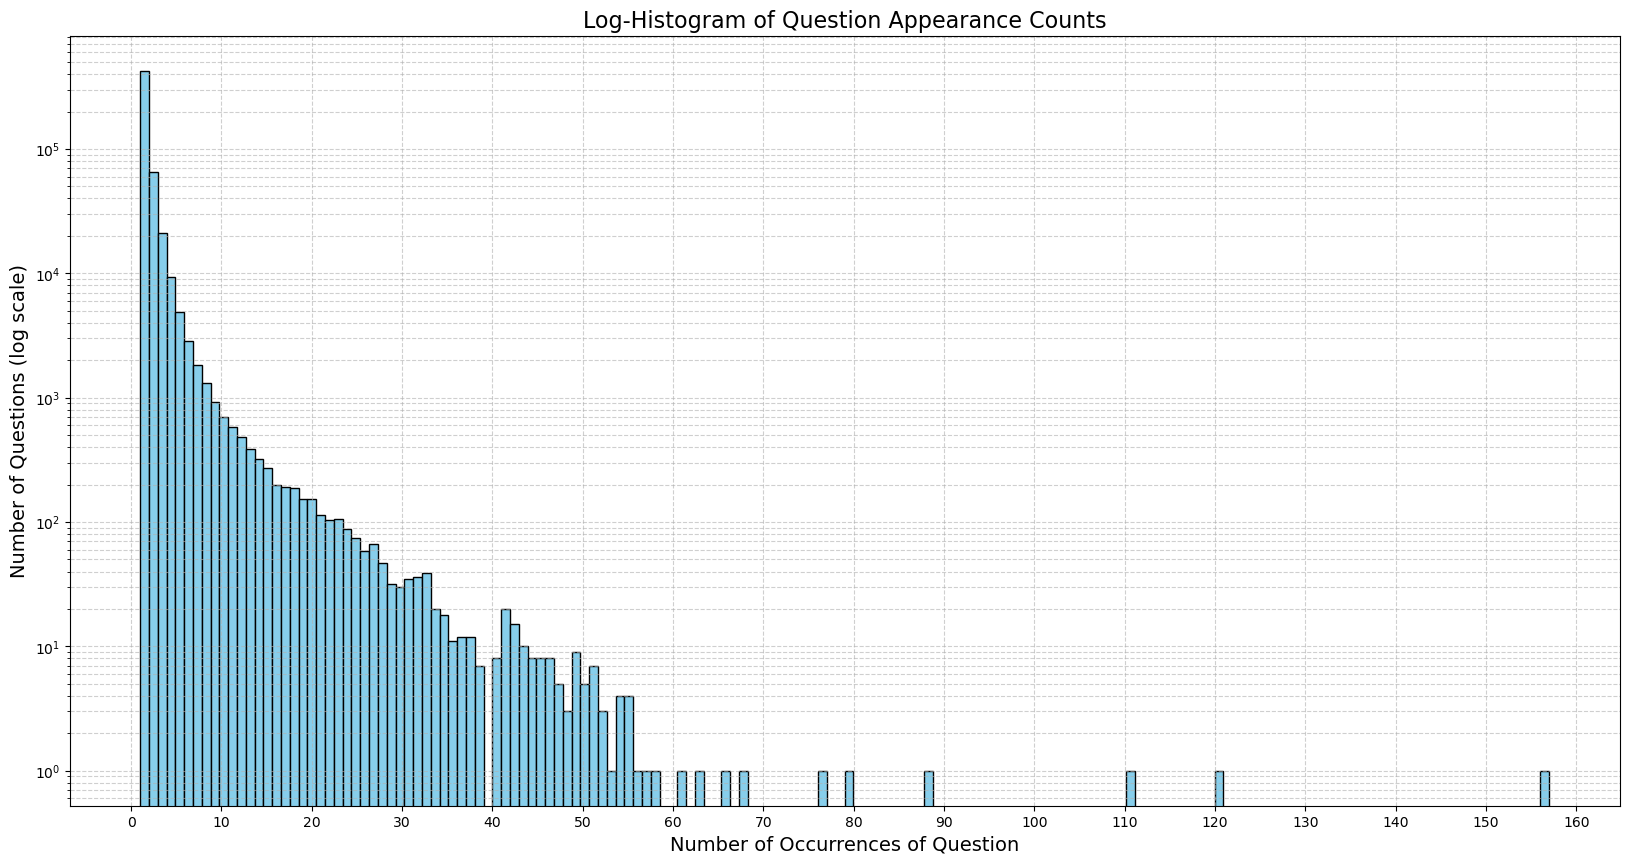

Maximum number of times a single question is repeated: 157



In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create a large figure
plt.figure(figsize=(20, 10))

# Plot histogram of question appearance counts
plt.hist(qids.value_counts(), bins=160, color='skyblue', edgecolor='black')

# Use logarithmic scale for y-axis
plt.yscale('log')

# Add title and axis labels
plt.title('Log-Histogram of Question Appearance Counts', fontsize=16)
plt.xlabel('Number of Occurrences of Question', fontsize=14)
plt.ylabel('Number of Questions (log scale)', fontsize=14)

# ✅ Set custom x-axis tick marks — show at every 10 steps up to max value
plt.xticks(np.arange(0, max(qids.value_counts()) + 10, 10))

# Add grid for clarity
plt.grid(True, which='both', linestyle='--', alpha=0.6)

# Display the plot
plt.show()

# Print max repetition info
print('Maximum number of times a single question is repeated: {}\n'
      .format(max(qids.value_counts())))


<h3> 3.2.5 Checking for NULL values </h3>

In [15]:
# Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(axis=1)]# check row wise
print(nan_rows)


            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [16]:
# Fill all NaN (missing) values in the DataFrame with empty strings ('')
df = df.fillna('')

# Check again if there are any rows that still contain null values
nan_rows = df[df.isnull().any(axis=1)]

# Print those rows (ideally this should print an empty DataFrame)
print(nan_rows)


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [17]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

In [18]:
# Let us now construct a few features like:

# freq_qid1 = Frequency of qid1's
# freq_qid2 = Frequency of qid2's
# q1len = Length of q1
# q2len = Length of q2
# q1_n_words = Number of words in Question 1
# q2_n_words = Number of words in Question 2
# word_Common = (Number of common unique words in Question 1 and Question 2)
# word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
# word_share = (word_common)/(word_Total)
# freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
# freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [19]:
import os
# Check if the feature-engineered CSV already exists.
# If yes → simply load it to save time.
# If no → create the new feature columns and store the CSV for future runs.
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv", encoding='latin-1')
else:
    # Frequency of appearance of qid1 (how many times this question appears in dataset)
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')

    # Frequency of appearance of qid2
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

    # Length (number of characters) in question1
    df['q1len'] = df['question1'].str.len()

    # Length (number of characters) in question2
    df['q2len'] = df['question2'].str.len()

    # Number of words in question1
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))

    # Number of words in question2
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    # -------------------------------------------------------------------------
    # COMMON WORD COUNT BETWEEN question1 & question2
    # -------------------------------------------------------------------------
    # Convert both questions to sets of lowercase words, remove spaces,
    # then count how many words are in common.
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)  # intersection size
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    # -------------------------------------------------------------------------
    # TOTAL WORDS = size of union (just sum of lengths of word sets)
    # -------------------------------------------------------------------------
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    # -------------------------------------------------------------------------
    # WORD SHARE = (common words) / (total words)
    # A useful similarity metric → higher means more similar questions
    # -------------------------------------------------------------------------
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2) / (len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    # -------------------------------------------------------------------------
    # Combining frequency features
    # freq_q1+q2 → how many times the pair of qid1 & qid2 appear in dataset
    # freq_q1-q2 → absolute difference in their frequencies
    # -------------------------------------------------------------------------
    df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

    # Save processed file to avoid recomputation next time
    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

# Show first few rows of dataframe
df.head()


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2>Analysis of some of the extracted features

In [20]:
# Print the minimum number of words that appear in any question in column 'question1'
print("Minimum length of the questions in question1 :", min(df['q1_n_words']))

# Print the minimum number of words that appear in any question in column 'question2'
print("Minimum length of the questions in question2 :", min(df['q2_n_words']))

# Count how many questions in 'question1' contain only 1 word (minimum length)
print("Number of Questions with minimum length [question1] :", 
      df[df['q1_n_words'] == 1].shape[0])

# Count how many questions in 'question2' contain only 1 word (minimum length)
print("Number of Questions with minimum length [question2] :", 
      df[df['q2_n_words'] == 1].shape[0])


Minimum length of the questions in question1 : 1
Minimum length of the questions in question2 : 1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h2>Feature: word_share

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2456\3415993113.py:19: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2456\3415993113.py:24: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




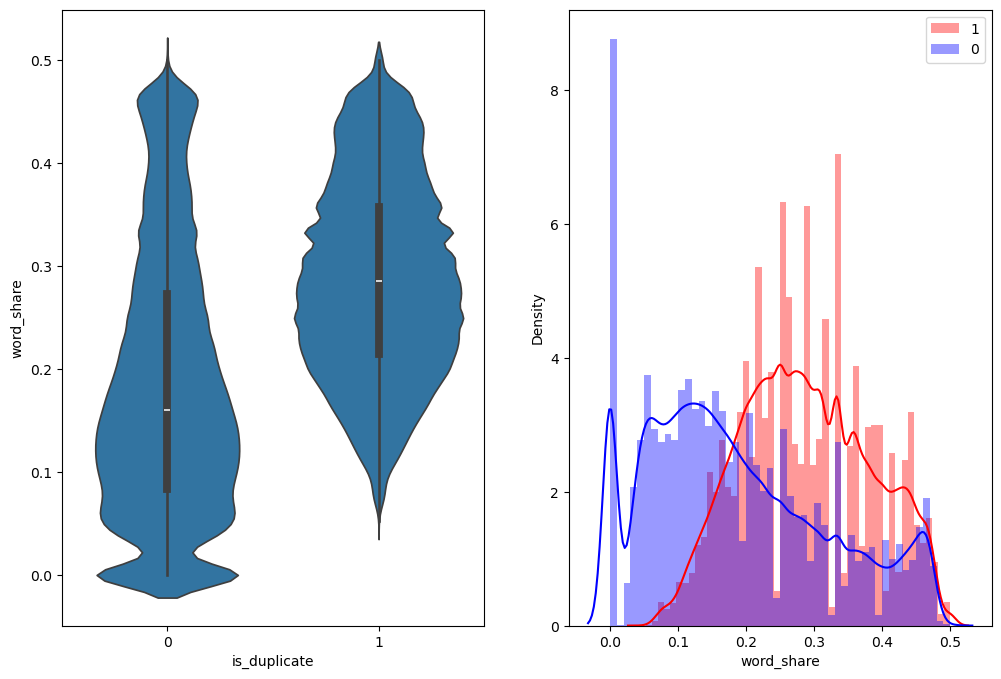

In [21]:
# Create a new figure with a width of 12 inches and height of 8 inches
plt.figure(figsize=(12, 8))

# ----------------------------- PLOT 1 ----------------------------------
# First subplot: 1 row, 2 columns, this is the 1st plot
plt.subplot(1, 2, 1)

# Violin plot showing distribution of 'word_share' for duplicate (1) and non-duplicate (0) questions
# x = is_duplicate (0 or 1)
# y = similarity score (word_share)
sns.violinplot(x='is_duplicate', y='word_share', data=df[0:])

# ----------------------------- PLOT 2 ----------------------------------
# Second subplot: 1 row, 2 columns, this is the 2nd plot
plt.subplot(1, 2, 2)

# Distribution plot for duplicate questions (is_duplicate = 1)
# Shows how 'word_share' values are spread when the pair is a duplicate
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], 
             label="1", color='red')

# Distribution plot for non-duplicate questions (is_duplicate = 0)
# Shows how 'word_share' values are spread when the pair is NOT a duplicate
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], 
             label="0", color='blue')

# Display both distributions together
plt.legend()

# Show the complete plot
plt.show()


In [22]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [23]:
# The distributions for normalized word_share have some overlap on the far right-hand side, i.e.,
# there are quite a lot of questions with high word similarity
# The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h2>Feature: word_Common

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2456\3497984339.py:18: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2456\3497984339.py:22: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




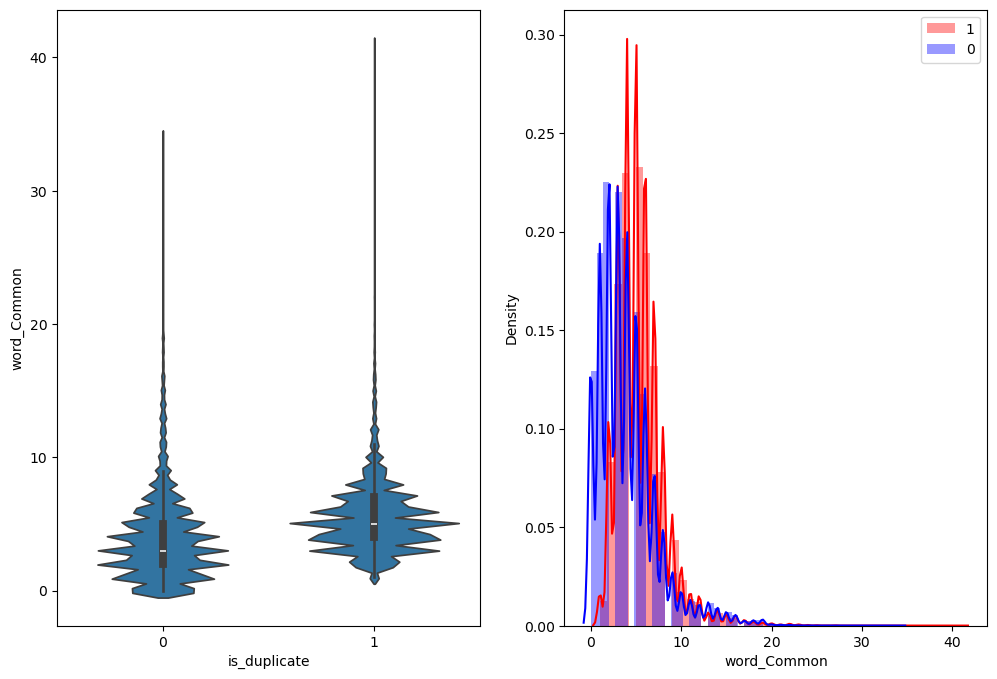

In [25]:
# Create a figure of size 12x8 for better visibility
plt.figure(figsize=(12, 8))

# ------------------------- PLOT 1: VIOLIN PLOT --------------------------
# First subplot (1 row, 2 columns → this is the 1st plot)
plt.subplot(1, 2, 1)

# Violin plot showing how many common words (word_Common) appear
# for duplicate (1) and non-duplicate (0) question pairs.
sns.violinplot(x='is_duplicate', y='word_Common', data=df[0:])
#df[0:] means: Take all rows from index 0 until the end."

# ------------------------- PLOT 2: DISTRIBUTION PLOT --------------------
# Second subplot (1 row, 2 columns → this is the 2nd plot)
plt.subplot(1, 2, 2)

# Plot distribution of common words for duplicate questions (is_duplicate = 1)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:],
             label="1", color='red')

# Plot distribution of common words for non-duplicate questions (is_duplicate = 0)
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:],
             label="0", color='blue')

# Display legend for 1 (duplicate) and 0 (non-duplicate)
plt.legend()

# Render both subplots
plt.show()
